# Dataset After Processing
### Project Title - An AI Perspective on the Cryptocurrency Market: Predicting Pump-and-Dump Schemes
### Team Members - Cyrena Burke and Daniel Olaes

## Overview & Setup
The initial dataset for the project is an accumulation of 6 different cryptocurrencies: 2 accurately demonstrate generally stable market behavior, BTC (Bitcoin) and ETH (Ethereum), and 4 that were the victims of pump-and-dump schemes during the 2017-2018 time frame available in our data, DOGE (Dogecoin), XRP (Ripple), XVG (Verge), and NXT (Nxt).

In [36]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data_processing"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Import Unprocessed Data
For the unprocessed data, the descriptive features are:
- **Unix Timestamp**: Timestamp created by Unix (interval)
- **Date**: The date and hour for that specific data point (interval / textual)
- **Symbol**: The cryptocurrency's stock symbol and currency symbol (categorical)
- **Open**: Opening price for that hour (numerical)
- **High**: Highest price during that hour (numerical)
- **Low**: Lowest price during that hour (numerical)
- **Close**: Closing price for that hour (numerical)
- **Volume Currency**: Amount of cryptocurrency traded during that hour (numerical)
- **Volume USD**: Amount of USD traded during that hour (numerical)

In [37]:
import pandas as pd
CRYPTO_FILE = "unprocessed_crypto_data.csv"
CRYPTO_PATH = os.path.join(".", CRYPTO_FILE)
crypto_data = pd.read_csv(CRYPTO_PATH)
crypto_data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume Currency,Volume USD
0,1528689600,2018-06-11 04-AM,DOGEUSD,0.003133,0.003135,0.003109,0.003116,1818890.0,5673.19
1,1528686000,2018-06-11 03-AM,DOGEUSD,0.003102,0.003185,0.003074,0.003133,2061200.0,6413.43
2,1528682400,2018-06-11 02-AM,DOGEUSD,0.003116,0.003192,0.003055,0.003102,2658060.0,8269.02
3,1528678800,2018-06-11 01-AM,DOGEUSD,0.003104,0.003123,0.003087,0.003116,976020.0,3023.88
4,1528675200,2018-06-11 12-AM,DOGEUSD,0.003106,0.003145,0.003094,0.003104,2637730.0,8215.86


In [38]:
print(f"Number of data points: {len(crypto_data)}")

Number of data points: 31595


## Data Cleaning
There are several instances in the data where **Volume Currency** and **Volume USD** are 0. This indicates that no transactions occurred during those hours, and such rows will not be useful for training our model.

In addition, we will drop any rows with missing values.

In addition, shuffling the dataset should be beneficial as well.

In [39]:
## Eliminate 0 cell rows
crypto_data = crypto_data[(crypto_data["Volume Currency"] != 0) & (crypto_data["Volume USD"] != 0)]
## Eliminate null cell rows
crypto_data = crypto_data.dropna()
## Shuffle the dataset
crypto_data = crypto_data.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Number of data points: {len(crypto_data)}")

Number of data points: 27858


## Feature Selection
The **Unix Timestamp** provides an integer interval feature for tracking dates and time. Therefore, we can utilize it over **Date**, which contains textual values that do not interact well with our numerical data.

In addition, we want to observe the general behavior of the cryptocurrency market. Therefore, we can eliminate the **Symbol** feature.

In [40]:
crypto_data = crypto_data.drop(["Date", "Symbol"], axis=1)
crypto_data.head()

,Unix Timestamp,Open,High,Low,Close,Volume Currency,Volume USD
0,1519948800,880.82000,885.57000,875.62000,878.84000,293.24,258092.72
1,1515625200,0.01247,0.01298,0.01241,0.01287,6185590.00,78674.57
2,1528178400,7471.87000,7497.14000,7461.21000,7477.24000,308.89,2309992.42
3,1511733600,9412.24000,9424.79000,9314.75000,9337.59000,184.91,1733771.37
4,1520175600,865.70000,869.00000,863.46000,868.51000,126.07,109158.24


## Kendall Correlation
A Kendall correlation heatmap allows us to visualize the negative and positive monotonic relationship between the features. The Kendall correlation was selected over Pearson correlation after some testing because the cryptocurrency market datapoints are not independent of each other and may not be normally distributed.

Saving figure initial_correlation_matrix_heatmap


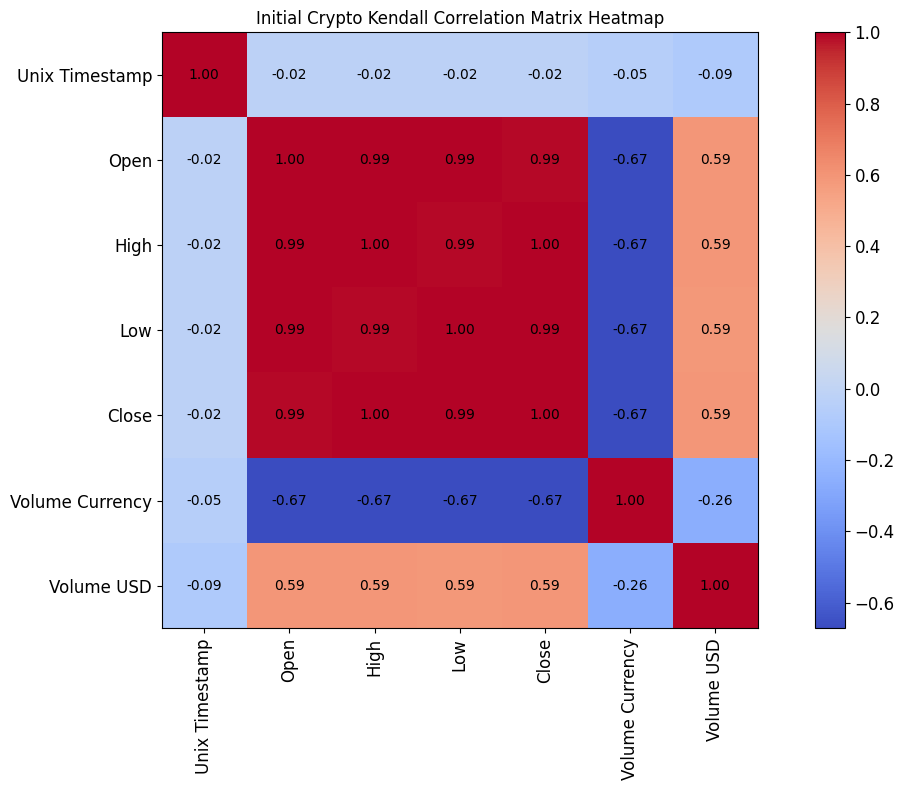

In [41]:
correlation_matrix = crypto_data.corr(method="kendall")

fig, ax = plt.subplots(figsize=(12, 8))

cax = ax.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns)
ax.set_yticklabels(correlation_matrix.columns)
plt.xticks(rotation=90)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        ax.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Initial Crypto Kendall Correlation Matrix Heatmap")
save_fig("initial_correlation_matrix_heatmap")   
plt.show()

The **Open**, **High**, **Low**, and **Close** prices are all closely positively correlated as they rise and fall together from hour to hour.

The **Volume Currency** shows a negative correlation to a majority of the price related features, which aligns with the "buy low, sell high" saying for stock trading.

It is unexpected that **Volume Currency** and **Volume USD** are negatively correlated. This may be due to differences in popularity and price between the cryptocurrencies.

## Feature Extraction and Selection
Because the features related to price are highly correlated, it may be beneficial to perform feature extraction to generate new features that may offer better insight about our data.

In [42]:
## Calculating the price change from opening price to closing price
crypto_data["Open to Close"] = crypto_data["Close"] - crypto_data["Open"]

## Calculating the price range between the highest and lowest prices of a given hour
crypto_data["Price Range"] = crypto_data["High"] - crypto_data["Low"]

## Drop features used in extraction
crypto_data = crypto_data.drop(["Close", "Open", "High", "Low"], axis=1)
crypto_data.head()

,Unix Timestamp,Volume Currency,Volume USD,Open to Close,Price Range
0,1519948800,293.24,258092.72,-1.9800,9.95000
1,1515625200,6185590.00,78674.57,0.0004,0.00057
2,1528178400,308.89,2309992.42,5.3700,35.93000
3,1511733600,184.91,1733771.37,-74.6500,110.04000
4,1520175600,126.07,109158.24,2.8100,5.54000


## Kendall Correlation After Feature Extraction

Saving figure correlation_matrix_heatmap


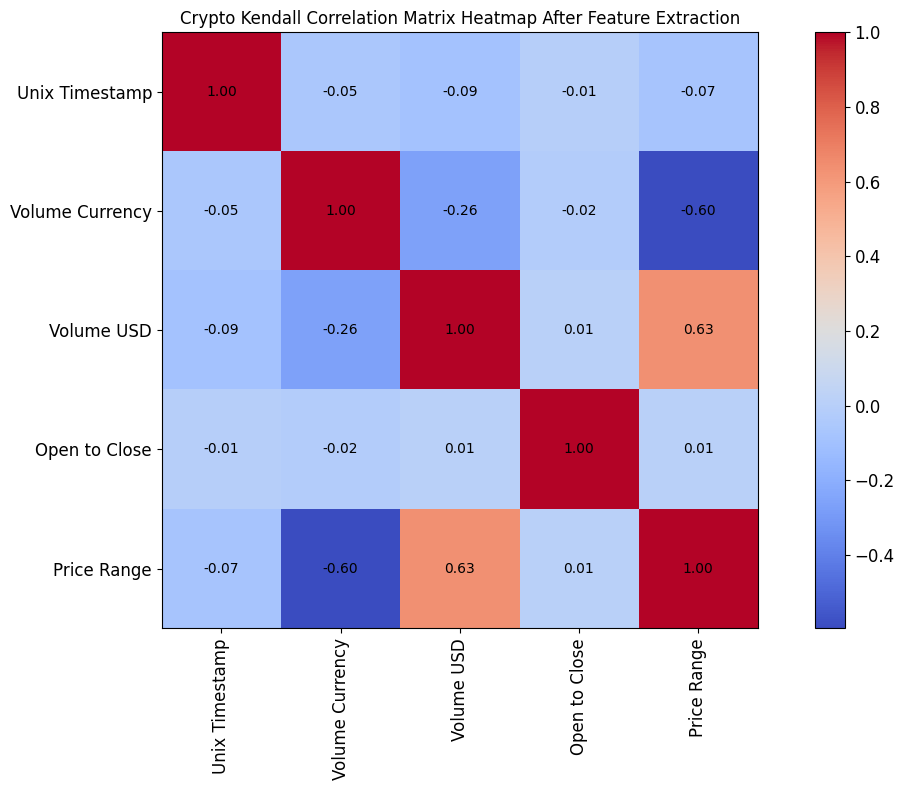

In [43]:
correlation_matrix = crypto_data.corr(method="kendall")

fig, ax = plt.subplots(figsize=(12, 8))

cax = ax.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns)
ax.set_yticklabels(correlation_matrix.columns)
plt.xticks(rotation=90)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        ax.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Crypto Kendall Correlation Matrix Heatmap After Feature Extraction")
save_fig("correlation_matrix_heatmap")   
plt.show()

**Price Range** is shown to be useful as it has strong negative correlation to **Volume Currency** and positive correlation to **Volume USD**.

In contrast, **Open to Close** is shown to not have any significant correlation to any of the other descriptive features. Therefore, it might be beneficial to remove it from consideration.

In [44]:
crypto_data = crypto_data.drop(["Open to Close"], axis=1)
crypto_data.head()

,Unix Timestamp,Volume Currency,Volume USD,Price Range
0,1519948800,293.24,258092.72,9.95000
1,1515625200,6185590.00,78674.57,0.00057
2,1528178400,308.89,2309992.42,35.93000
3,1511733600,184.91,1733771.37,110.04000
4,1520175600,126.07,109158.24,5.54000


## Visualize Final Descriptive Features
These final descriptive features will be useful for training our model to identify intentional market manipulation because dramatic price swings with high trade volumes may indicate irregular market behavior.

Saving figure final_descriptive_features_scatter_plots


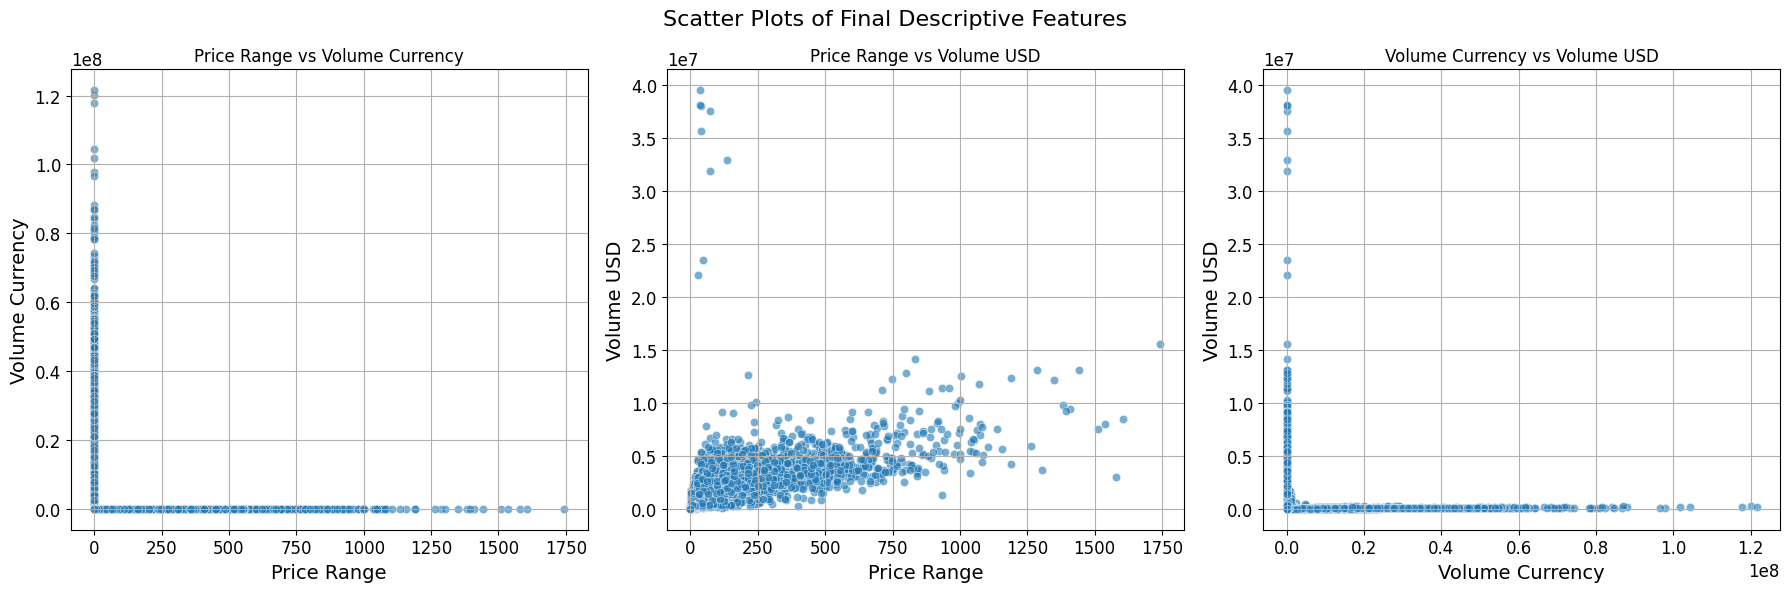

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature pairs
feature_pairs = [
    ("Price Range", "Volume Currency"),
    ("Price Range", "Volume USD"),
    ("Volume Currency", "Volume USD")
]

# Create scatter plots
plt.figure(figsize=(18, 6))

for i, (x, y) in enumerate(feature_pairs, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=crypto_data, x=x, y=y, alpha=0.6)
    plt.title(f"{x} vs {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)

plt.suptitle("Scatter Plots of Final Descriptive Features", fontsize=16)
save_fig("final_descriptive_features_scatter_plots") 
plt.show()

While the scatter plots of final descriptive features provide insight on the data distribution, the axes reveal that another problem with our data is the dramatically differing numerical ranges between features.

## Export Processed Data
Now that our data has been processed, it is ready to be utilized in training our model.

In [46]:
crypto_data.to_csv("processed_crypto_data.csv", index=False)
print("Data Processed and Exported")

Data Processed and Exported
